<a href="https://colab.research.google.com/github/tago893/Algoproject-TSP/blob/main/Project_f_random_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install plotly

###For 10 cities

Enter the number of points: 10


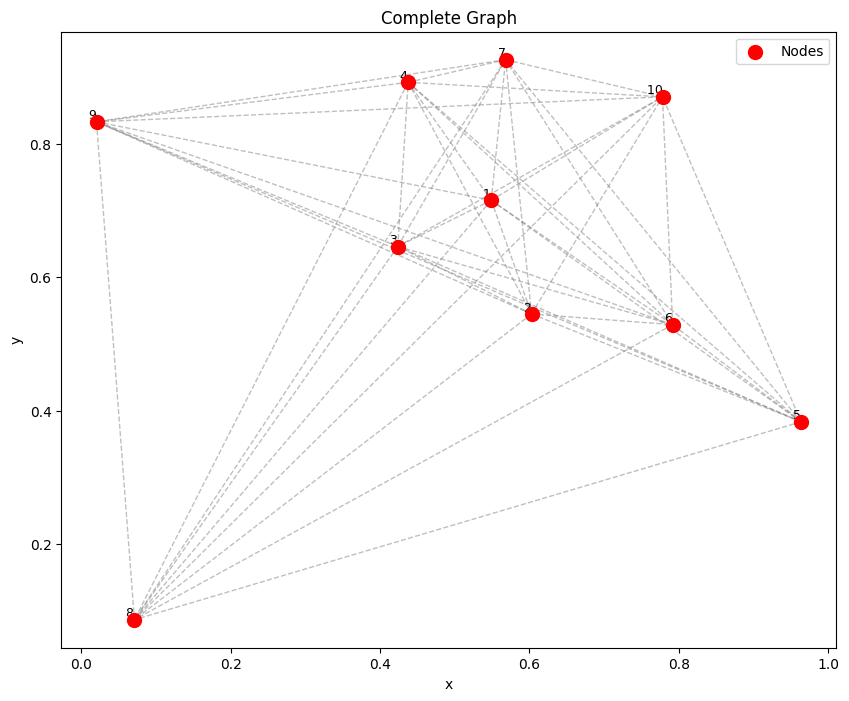

Running Christofides Algorithm...


Best Path Distance (Christofides): (4.707603077994739, 12)
Execution time (Christofides): 0.005043983459472656
Running Lin-Kernighan Algorithm...


Best Path Distance (Lin-Kernighan): (3.438885012668645, 13)
Execution time (Lin-Kernighan): 0.005071878433227539
Running Nearest Neighbor Algorithm...


Best Path Distance (Nearest Neighbor): 3.594273913037621
Execution time(Nearest Neighbor): 9.751319885253906e-05


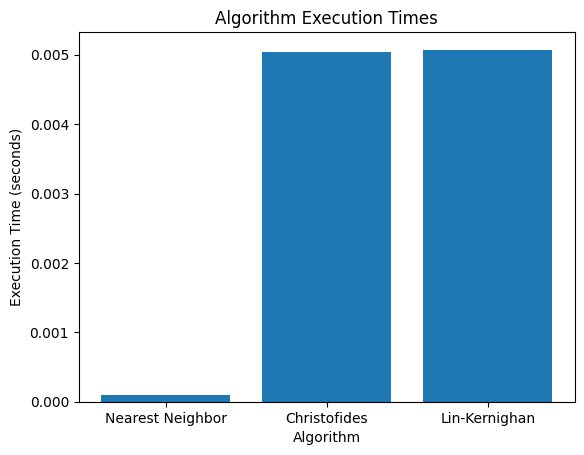

In [2]:
import numpy as np
import plotly.graph_objects as go
from scipy.spatial.distance import pdist, squareform
import string
import time
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations

def calculate_distances(points):
    return squareform(pdist(points, metric='euclidean'))

def create_complete_graph(point_count, distances):
    G = nx.Graph()  # Use Graph for an undirected graph
    for i, j in combinations(range(point_count), 2):
        G.add_edge(i, j, weight=distances[i][j])
    return G


def run_christofides_algorithm(points, distances):
    start_time = time.time()
    G = create_complete_graph(len(points), distances)
    T = nx.minimum_spanning_tree(G)
    odd_degree_nodes = [node for node in T.nodes if T.degree(node) % 2 == 1]
    matching = nx.max_weight_matching(G.subgraph(odd_degree_nodes), maxcardinality=True)
    M = nx.MultiGraph(T)
    M.add_edges_from(matching)
    euler_tour = list(nx.eulerian_circuit(M))
    hamiltonian_tour = [euler_tour[i][0] for i in range(len(euler_tour))]
    hamiltonian_tour.append(hamiltonian_tour[0])  # Return to the starting city
    total_distance = calculate_path_distance(hamiltonian_tour, distances)
    end_time = time.time()
    execution_time = end_time - start_time
    return hamiltonian_tour, total_distance, execution_time

def calculate_path_distance(path, distances):
    total_distance = 0
    edge_count = 0
    for i in range(len(path) - 1):
        total_distance += distances[path[i]][path[i + 1]]
        edge_count += 1
    return total_distance, edge_count
def reverse_subsequence(tour, start_index, end_index):
    tour[start_index:end_index + 1] = tour[start_index:end_index + 1][::-1]

def calculate_total_distance(tour, distances):
    total_distance = 0
    for i in range(len(tour) - 1):
        total_distance += distances[tour[i]][tour[i+1]]
    total_distance += distances[tour[-1]][tour[0]]
    return total_distance

def lin_kernighan(tour, distances):
    start_time = time.time()

    best_tour = tour[:]
    best_cost = calculate_path_distance(best_tour, distances)

    while True:
        best_swap = None
        for i in range(1, len(tour) - 2):
            for j in range(i + 1, len(tour) - 1):
                new_tour = best_tour[:]
                reverse_subsequence(new_tour, i, j)
                new_cost = calculate_path_distance(new_tour + [new_tour[0]], distances)
                if new_cost < best_cost:
                    best_swap = (i, j)
                    best_cost = new_cost

        if best_swap is None:
            break
        else:
            reverse_subsequence(best_tour, best_swap[0], best_swap[1])

    end_time = time.time()
    execution_time = end_time - start_time
    return best_tour , best_cost, execution_time


def run_nearest_neighbor_algorithm(points, distances, start_index=0):
    start_time = time.time()

    current_index = start_index
    unvisited = set(range(len(points)))
    unvisited.remove(current_index)
    path = [current_index]
    total_distance = 0

    while unvisited:
        nearest_index = min(unvisited, key=lambda x: distances[current_index][x])
        total_distance += distances[current_index][nearest_index]
        path.append(nearest_index)
        unvisited.remove(nearest_index)
        current_index = nearest_index

    total_distance += distances[path[-1]][start_index]
    path.append(start_index)

    end_time = time.time()
    execution_time = end_time - start_time
    return path, total_distance, execution_time
def plot_complete_graph(points):
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(points[:, 0], points[:, 1], color='red', s=100, zorder=5, label='Nodes')

    # Drawing edges
    for i in range(len(points)):
        for j in range(i+1, len(points)):
            ax.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]], 'gray', linestyle='--', lw=1, alpha=0.5)

    # Annotating points
    for i, point in enumerate(points):
        ax.text(point[0], point[1], f' {i+1}', verticalalignment='bottom', horizontalalignment='right', fontsize=9, color='black')

    ax.set_title("Complete Graph")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    plt.show()

def index_to_identifier(index):
    return 'Node '+str(index + 1)

def plot_path(fig, points, path, color='blue', point_names=None):
    # Check if point_names are provided, else create default names
    if point_names is None:
        point_names = [f'Node {i+1}' for i in range(len(points))]

    # Plot the nodes with distinct markers, names, and a different name
    node_trace = go.Scatter(x=points[:, 0], y=points[:, 1],
                            mode='markers+text', marker=dict(color='red', size=12),
                            text=point_names, textposition='top center',
                            name='Nodes')

    fig.add_trace(node_trace)

    # Plot the path as lines between nodes
    for i in range(len(path) - 1):
        edge_trace = go.Scatter(x=[points[path[i]][0], points[path[i+1]][0]],
                                y=[points[path[i]][1], points[path[i+1]][1]],
                                mode='lines+markers', line=dict(color=color),
                                name=f'Path {i}', showlegend=False)
        fig.add_trace(edge_trace)

    # Connect the last node to the first to close the path
    closing_edge_trace = go.Scatter(x=[points[path[-1]][0], points[path[0]][0]],
                                    y=[points[path[-1]][1], points[path[0]][1]],
                                    mode='lines+markers', line=dict(color=color),
                                    name='Path End', showlegend=False)
    fig.add_trace(closing_edge_trace)


def main():
    try:
        point_count = int(input("Enter the number of points: "))
    except ValueError:
        print("Invalid input! Please enter a valid integer.")
        return

    np.random.seed(0)
    points = np.random.rand(point_count, 2)
    distances = calculate_distances(points)

    # Display the complete graph with all weights
    plot_complete_graph(points)
    print("Running Christofides Algorithm...")
    path_christofides, total_distance_christofides,christofides_execution_time = run_christofides_algorithm(points, distances)
    letter_path_christofides = [index_to_identifier(index) for index in path_christofides]

    fig = go.Figure()
    plot_path(fig, points, path_christofides, color='green')
    fig.update_layout(title_text="Christofides Graph", xaxis_title="x", yaxis_title="y")
    fig.show()

    #print("Best Path (Christofides):", letter_path_christofides)
    print("Best Path Distance (Christofides):", total_distance_christofides)
    print("Execution time (Christofides):", christofides_execution_time)

    print("Running Lin-Kernighan Algorithm...")
    initial_tour = path_christofides
    path_lin_kernighan, total_distance_lin_kernighan, lin_kernighan_execution_time = lin_kernighan(initial_tour, distances)
    letter_path_lin_kernighan = [index_to_identifier(index) for index in path_lin_kernighan]

    fig = go.Figure()
    plot_path(fig, points, path_lin_kernighan, color='blue')
    fig.update_layout(title_text="Lin-Kernighan Algorithm", xaxis_title="x", yaxis_title="y")
    fig.show()

    #print("Best Path (Lin-Kernighan):", letter_path_lin_kernighan)
    print("Best Path Distance (Lin-Kernighan):", total_distance_lin_kernighan)
    print("Execution time (Lin-Kernighan):", lin_kernighan_execution_time)

    print("Running Nearest Neighbor Algorithm...")
    path_nearest_neighbor, total_distance_nearest_neighbor, nearest_neighbor_execution_time = run_nearest_neighbor_algorithm(points, distances)
    letter_path_nearest_neighbor = [index_to_identifier(index) for index in path_nearest_neighbor]

    fig = go.Figure()
    plot_path(fig, points, path_nearest_neighbor, color='grey')
    fig.update_layout(title_text="Nearest Neighbor Algorithm", xaxis_title="x", yaxis_title="y")
    fig.show()

    #print("Best Path (Nearest Neighbor):", letter_path_nearest_neighbor)
    print("Best Path Distance (Nearest Neighbor):", total_distance_nearest_neighbor)
    print("Execution time(Nearest Neighbor):", nearest_neighbor_execution_time)

    # Executing algorithms and measuring execution times
    execution_times = [nearest_neighbor_execution_time, christofides_execution_time, lin_kernighan_execution_time]
    algorithms = ["Nearest Neighbor", "Christofides", "Lin-Kernighan"]

    # Creating a bar plot for algorithm execution times
    plt.bar(algorithms, execution_times)
    plt.title("Algorithm Execution Times")
    plt.xlabel("Algorithm")
    plt.ylabel("Execution Time (seconds)")
    plt.show()



if __name__ == "__main__":
    main()

###For 25 cities

Enter the number of points: 25


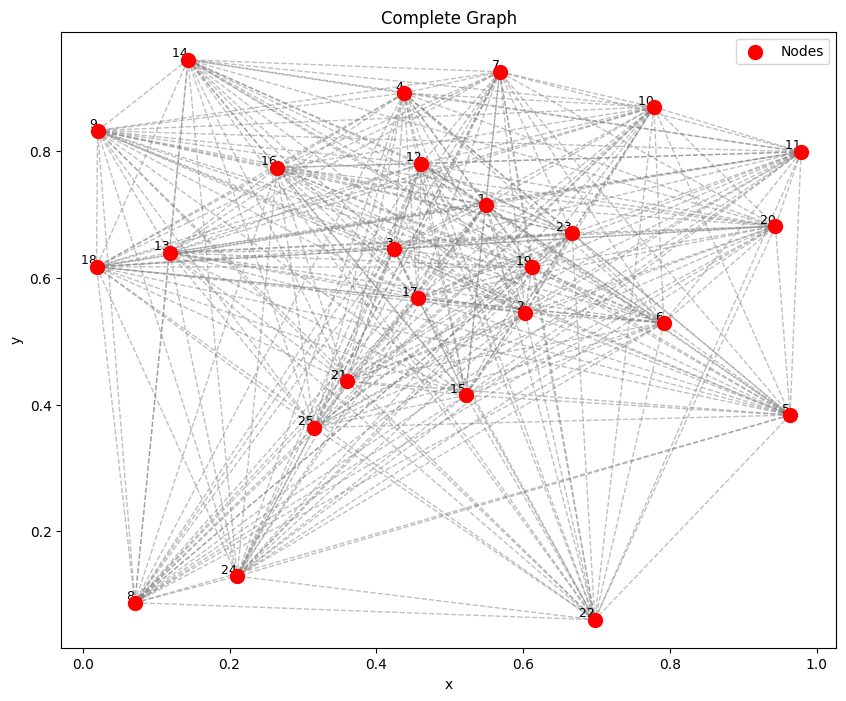

Running Christofides Algorithm...


Best Path Distance (Christofides): (8.039280046287534, 29)
Execution time (Christofides): 0.02353048324584961
Running Lin-Kernighan Algorithm...


Best Path Distance (Lin-Kernighan): (4.786996897614424, 30)
Execution time (Lin-Kernighan): 0.24713826179504395
Running Nearest Neighbor Algorithm...


Best Path Distance (Nearest Neighbor): 5.976671497058518
Execution time(Nearest Neighbor): 0.00029015541076660156


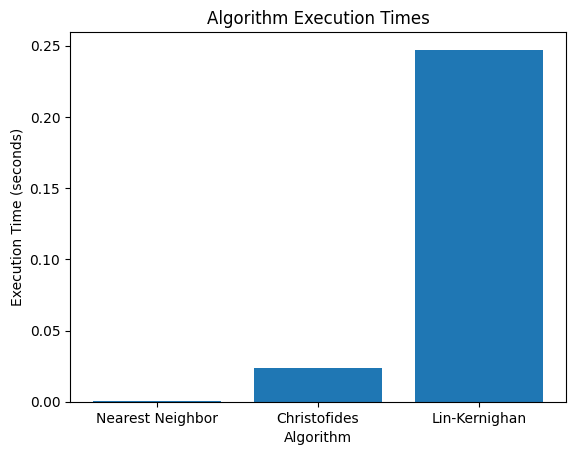

In [3]:
main()

###For 30 cities

Enter the number of points: 30


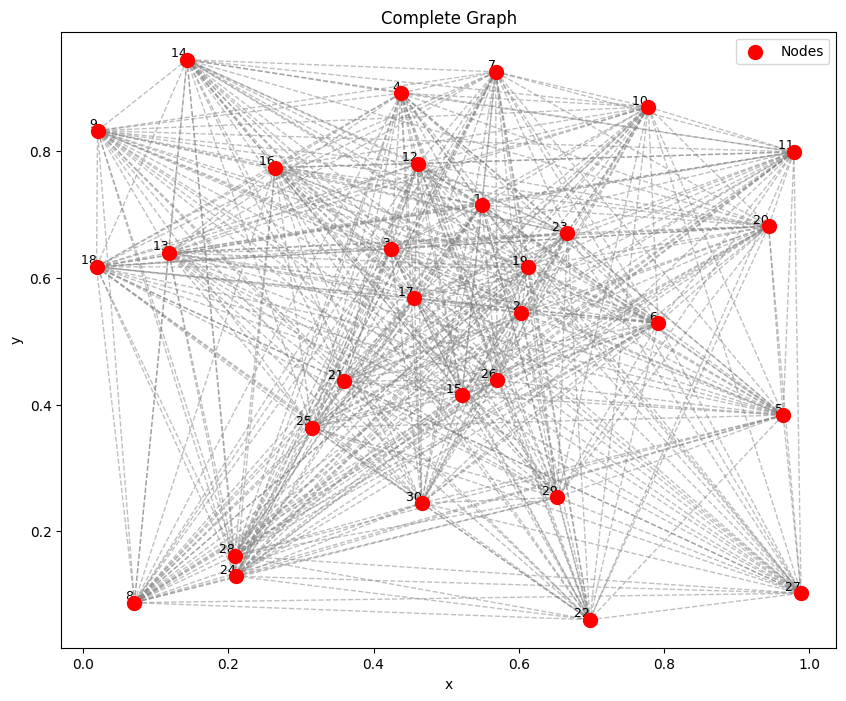

Running Christofides Algorithm...


Best Path Distance (Christofides): (8.69295558578098, 34)
Execution time (Christofides): 0.013671159744262695
Running Lin-Kernighan Algorithm...


Best Path Distance (Lin-Kernighan): (5.128905655514509, 35)
Execution time (Lin-Kernighan): 0.20381641387939453
Running Nearest Neighbor Algorithm...


Best Path Distance (Nearest Neighbor): 6.295825880106995
Execution time(Nearest Neighbor): 0.00035452842712402344


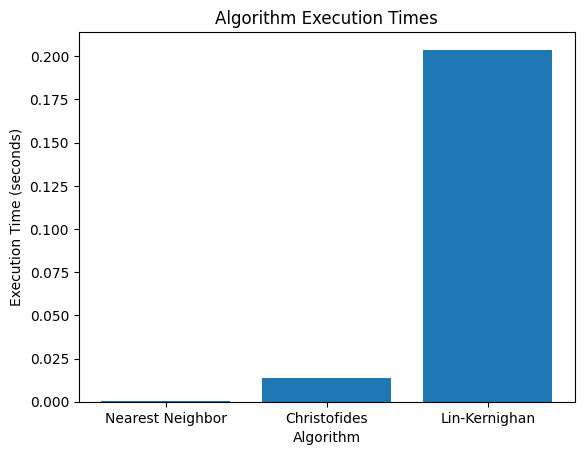

In [4]:
main()

###For 50 cities

Enter the number of points: 50


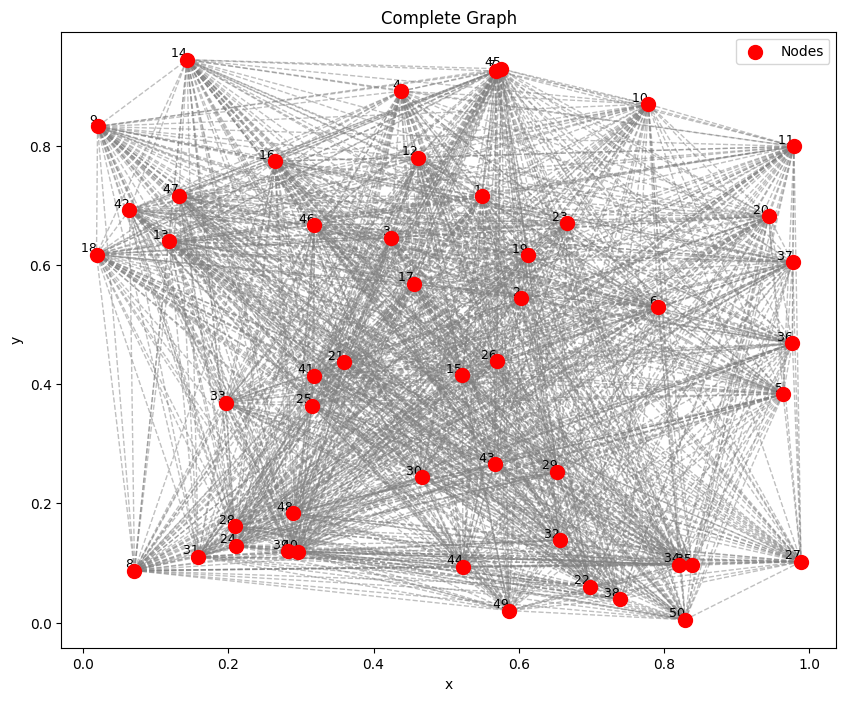

Running Christofides Algorithm...


Best Path Distance (Christofides): (14.403924285062994, 61)
Execution time (Christofides): 0.2182755470275879
Running Lin-Kernighan Algorithm...


Best Path Distance (Lin-Kernighan): (6.018781180196016, 62)
Execution time (Lin-Kernighan): 1.6452248096466064
Running Nearest Neighbor Algorithm...


Best Path Distance (Nearest Neighbor): 6.266256008408186
Execution time(Nearest Neighbor): 0.000812530517578125


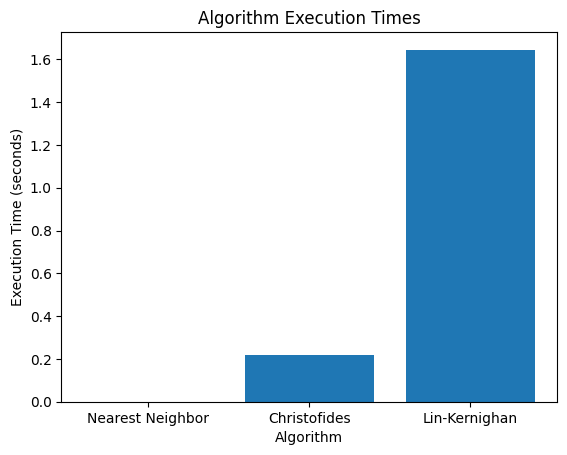

In [5]:
main()

###For 100 cities

Enter the number of points: 100


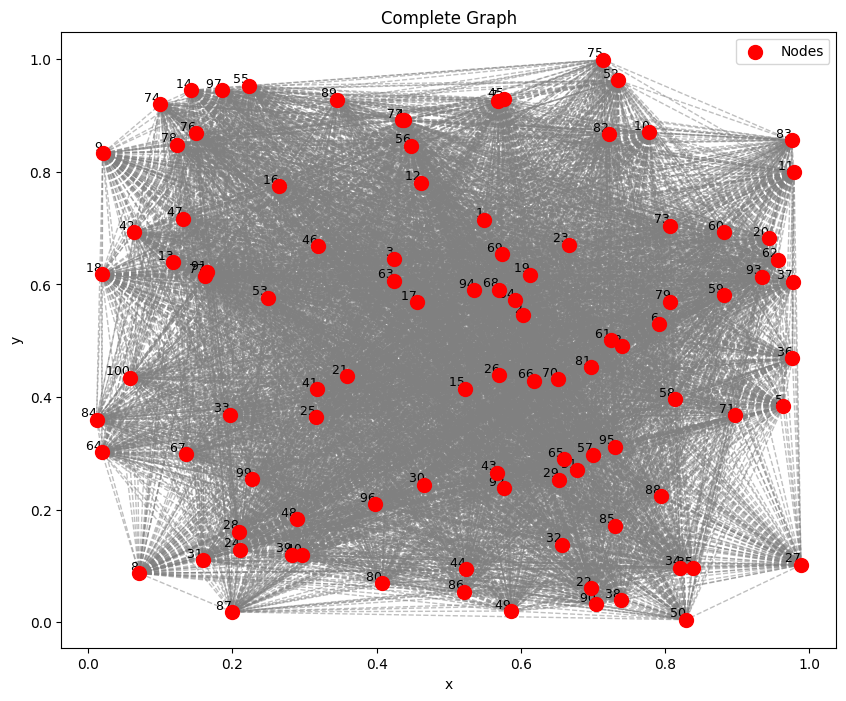

Running Christofides Algorithm...


Best Path Distance (Christofides): (23.06307333026971, 120)
Execution time (Christofides): 0.6834969520568848
Running Lin-Kernighan Algorithm...


Best Path Distance (Lin-Kernighan): (8.194897322222468, 121)
Execution time (Lin-Kernighan): 34.28229904174805
Running Nearest Neighbor Algorithm...


Best Path Distance (Nearest Neighbor): 10.834714689417956
Execution time(Nearest Neighbor): 0.003940105438232422


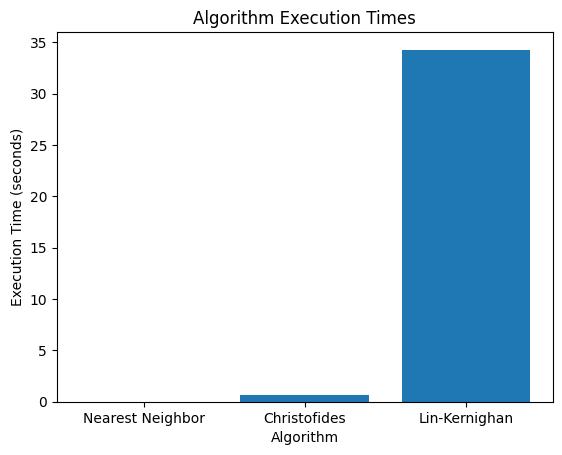

In [6]:
main()

###For 200 cities

Enter the number of points: 200


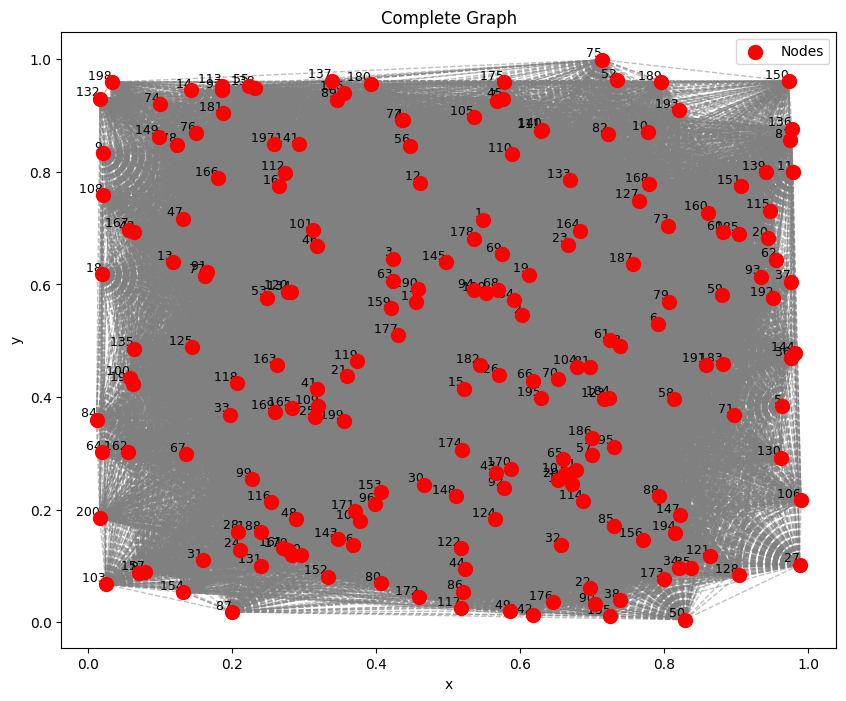

Running Christofides Algorithm...


Best Path Distance (Christofides): (37.90863333747361, 237)
Execution time (Christofides): 1.5578904151916504
Running Lin-Kernighan Algorithm...


Best Path Distance (Lin-Kernighan): (11.114886125186208, 238)
Execution time (Lin-Kernighan): 296.34913301467896
Running Nearest Neighbor Algorithm...


Best Path Distance (Nearest Neighbor): 13.734306326193634
Execution time(Nearest Neighbor): 0.012430429458618164


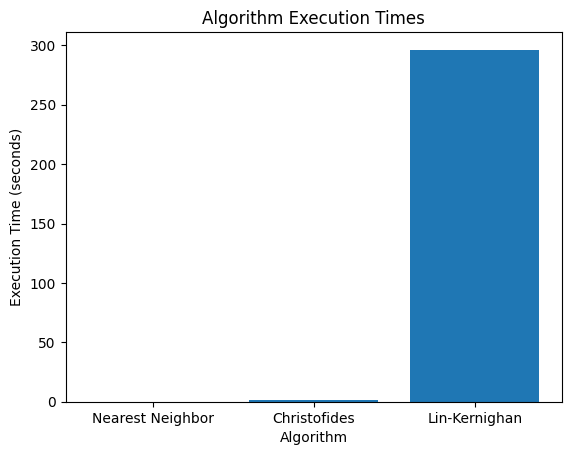

In [7]:
main()

###For 300 cities

Enter the number of points: 300


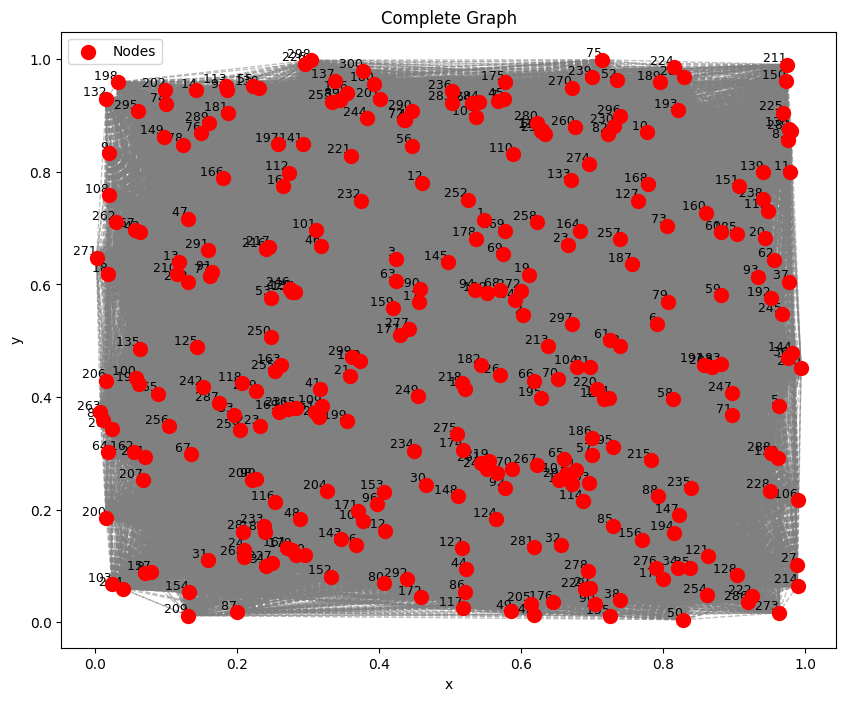

Running Christofides Algorithm...


Best Path Distance (Christofides): (56.828425742527955, 360)
Execution time (Christofides): 9.784669160842896
Running Lin-Kernighan Algorithm...


Best Path Distance (Lin-Kernighan): (13.419865842606209, 361)
Execution time (Lin-Kernighan): 1536.0233097076416
Running Nearest Neighbor Algorithm...


Best Path Distance (Nearest Neighbor): 15.352491700181842
Execution time(Nearest Neighbor): 0.028116703033447266


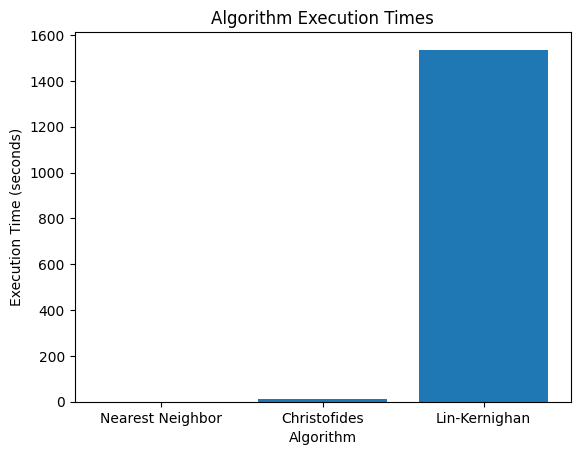

In [8]:
main()

###For 500 cities

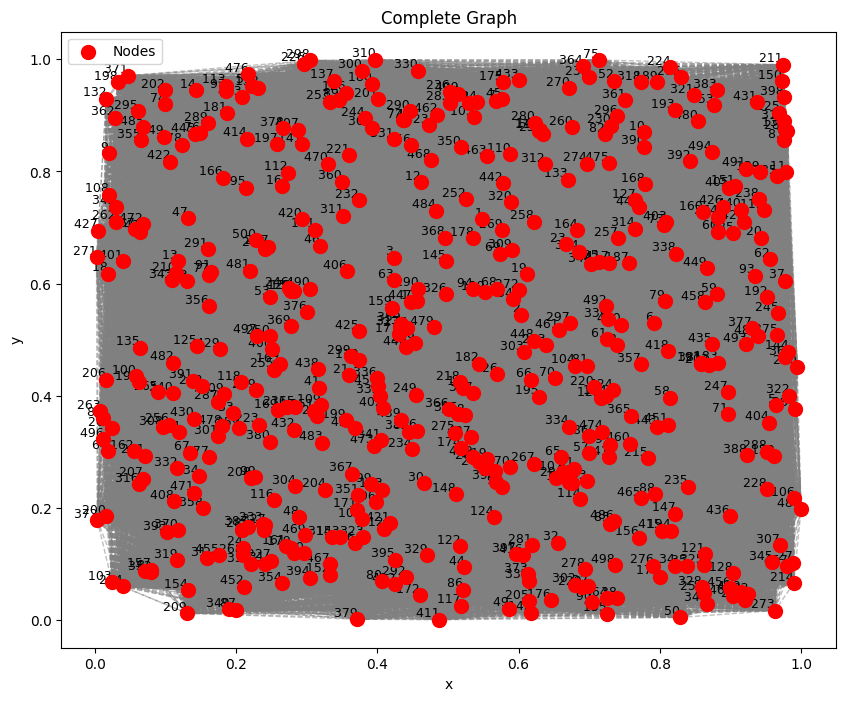

Running Christofides Algorithm...


Best Path Distance (Christofides): (99.54736474939604, 605)
Execution time (Christofides): 33.06830191612244
Running Lin-Kernighan Algorithm...


Best Path Distance (Lin-Kernighan): (17.296421570667345, 606)
Execution time (Lin-Kernighan): 13332.937192440033
Running Nearest Neighbor Algorithm...


Best Path Distance (Nearest Neighbor): 21.6360832684487
Execution time(Nearest Neighbor): 0.05923891067504883


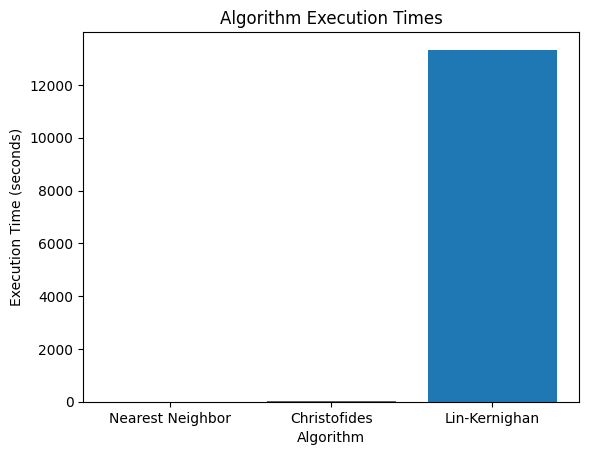

In [9]:
main()

##DISTANCE AND  TIME VS NODES PLOTS

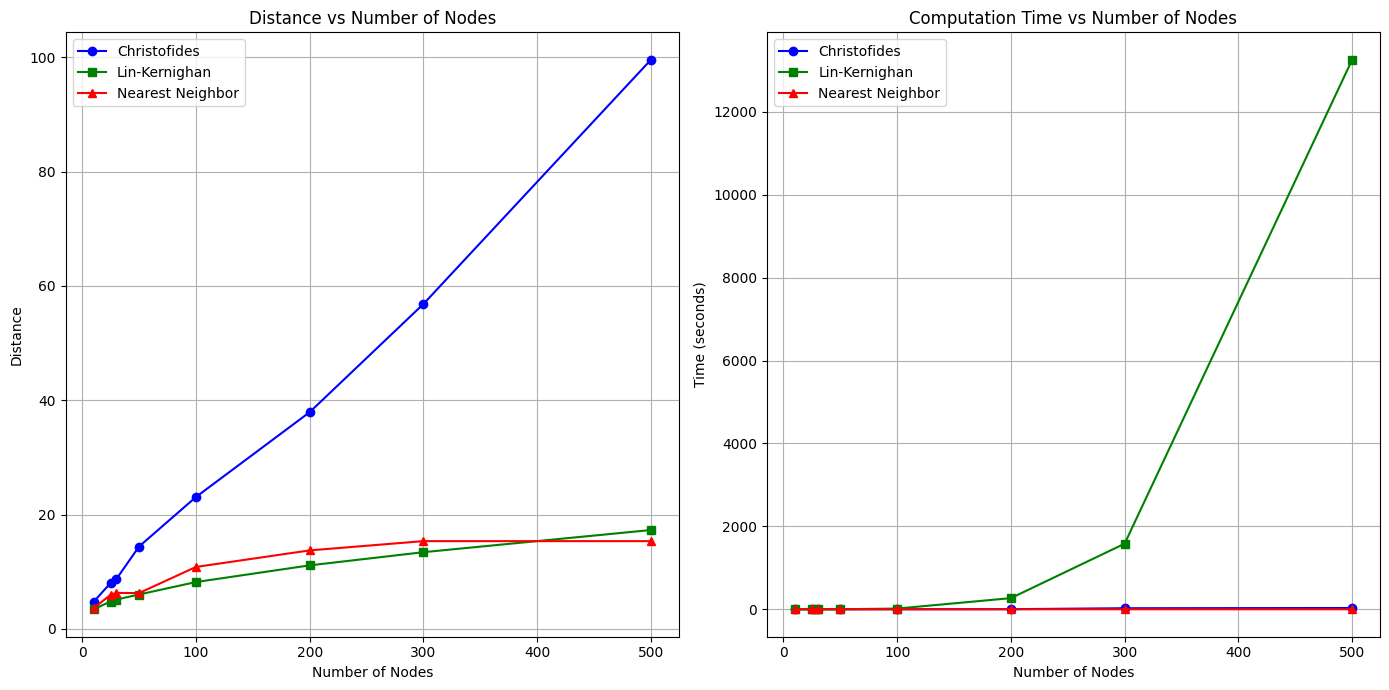

In [10]:
import matplotlib.pyplot as plt

# Data from the table
nodes = [10, 25, 30, 50, 100, 200, 300, 500]
distances_CH = [4.707603077994739, 8.039280046287534, 8.69295558578098, 14.403924285062994, 23.06307333026971, 37.90863333747361, 56.828425742527955, 99.54736474939604]
times_CH = [0.013050317764282227, 0.00899052619934082, 0.010630369186401367, 0.06866598129272461, 0.2669804096221924, 1.947399377822876, 24.29776167869568, 29.880012273788452]

distances_LK = [3.438885012668645, 4.786996897614424, 5.128905655514509, 6.018781180196016, 8.194897322222468, 11.114886125186208, 13.419865842606209, 17.296421570667345]
times_LK = [0.002989530563354492, 0.12700700759887695, 0.20109963417053223, 0.0009989738464355469, 16.494138956069946, 268.13975954055786, 1581.9635274410248, 13255.052483558655]

distances_NN = [3.594273913037621, 5.976671497058518, 6.295825880106995, 6.266256008408186, 10.834714689417956, 13.734306326193634, 15.352491700181842, 15.352491700181842]
times_NN = [8.153915405273438e-05, 0.0009989738464355469, 0.00032830238342285156, 0.0009970664978027344, 0.000997304916381836, 0.008122682571411133, 0.017824172973632812, 0.07654309272766113]

# Let's try plotting the data using a different approach, by creating separate subplots for distance and time.

plt.figure(figsize=(14, 7))

# First subplot for distances
plt.subplot(1, 2, 1)
plt.plot(nodes, distances_CH, 'o-', label='Christofides', color='blue')
plt.plot(nodes, distances_LK, 's-', label='Lin-Kernighan', color='green')
plt.plot(nodes, distances_NN, '^-', label='Nearest Neighbor', color='red')
plt.xlabel('Number of Nodes')
plt.ylabel('Distance')
plt.title('Distance vs Number of Nodes')
plt.legend()
plt.grid(True)

# Second subplot for times
plt.subplot(1, 2, 2)
plt.plot(nodes, times_CH, 'o-', label='Christofides', color='blue')
plt.plot(nodes, times_LK, 's-', label='Lin-Kernighan', color='green')
plt.plot(nodes, times_NN, '^-', label='Nearest Neighbor', color='red')
plt.xlabel('Number of Nodes')
plt.ylabel('Time (seconds)')
plt.title('Computation Time vs Number of Nodes')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

